<h1><font color="#113D68" size=6>Tema 2 - Comptuación Evolutiva</font></h1>

<h1><font color="#113D68" size=5>Ampliación de Sistemas Inteligentes (CÓDIGO 71014069)</font></h1>

<h1><font color="#113D68" size=4>3. Codificación real: GA reales y Estrategias de Evolución</font></h1>

<br><br>
<div style="text-align: right">
<font color="#113D68" size=3>Manuel Castillo-Cara</font><br>
</div>


---

**Objetivo.** Optimización continua con operadores para variables reales y comparación frente a ES clásicas.

**Contenido.**
- Cruces: aritmético, BLX–$\alpha$ (con *clipping* al rango válido), SBX (opcional).
- Mutaciones: gaussiana y **no-uniforme corregida** $\Delta(t,y)=y\cdot\big(1-r^{(1-t/T)^b}\big)$.
- ES $(\mu,\lambda)$ y $(\mu+\lambda)$ con mutación gaussiana (step-size fijo).
- Benchmarks: **Sphere**, **Rosenbrock**, **Ackley**.
- Visualización: convergencia, trayectorias 2D/contornos, histograma de pasos.

> **Notas de erratas del curso:**  
> 1) En mutación no-uniforme la corrección correcta es $\Delta(t,y)=y\cdot(1-r^{(1-t/T)^b})$ (no $1/T$).  
> 2) En BLX–$\alpha$ los hijos deben **recortarse** al rango permitido.  
> 3) En ranking lineal, $a_{\min}=2-a_{\max}$ con $1<a_{\max}\le2$ para probabilidades normalizadas.

In [1]:
# === 0) Imports y utilidades de tu módulo ===
import numpy as np
import matplotlib.pyplot as plt
from tintoutils import multi_run, summarize_runs, plot_convergence, plot_best_so_far, run_and_time, boxplot_fbest

def set_seed(seed=1234):
    return np.random.default_rng(seed)

---

<a id="indice"></a>
# <font color="#004D7F" size=6>Índice</font>

1. [Funciones objetivo y dominios estándar](#intro)
2. [Operadores para variables reales](#api)
3. [Selección (torneo/ranking) y GA continuo generacional](#algos)
4. [ES (µ,λ) y (µ+λ) (step-size fijo, mutación gaussiana)](#obj)
5. [Demostración rápida en Sphere (D=10): GA (BLX) vs ES](#single)
6. [Trayectorias 2D en Ackley y análisis de tamaño de paso](#multirun)
7. [Comparativa multi-run (GA vs ES) en Sphere y Ackley](#bench)
8. [Notas finales](#vis2d)

---

<a id="intro"></a>
# <font color="#004D7F" size=6>1. Funciones objetivo y dominios estándar</font>

En este bloque se definen las funciones de prueba o **benchmarks clásicos** utilizados en optimización continua. Estas funciones permiten evaluar y comparar el rendimiento de algoritmos evolutivos bajo condiciones controladas. Se implementan las siguientes:

- **Sphere:**  
  $f(x) = \sum_i x_i^2$  
  Es una función convexa, unimodal y suave, cuyo mínimo global está en $x^* = 0$.  
  Se utiliza para medir la *velocidad de convergencia* del algoritmo.

- **Rosenbrock:**  
  $f(x) = \sum_i [100(x_{i+1} - x_i^2)^2 + (1 - x_i)^2]$  
  Presenta un valle curvado y estrecho que dificulta la búsqueda del mínimo global en $(1,1,\dots,1)$.  
  Evalúa la capacidad del algoritmo para manejar **problemas mal condicionados**.

- **Ackley:**  
  $f(x) = -a\,e^{-b\sqrt{\frac{1}{d}\sum x_i^2}} - e^{\frac{1}{d}\sum \cos(c x_i)} + a + e$  
  Es una función multimodal con muchos mínimos locales, donde el global está en $x^*=0$.  
  Se usa para analizar la **capacidad exploratoria** frente a paisajes con múltiples óptimos locales.

Además, se define un diccionario `DOM` con los **rangos válidos** de búsqueda por variable:
- `Sphere`: $[-5, 5]$
- `Rosenbrock`: $[-2, 2]$
- `Ackley`: $[-5, 5]$

Estos rangos aseguran comparaciones justas y evitan extrapolaciones fuera del dominio relevante de cada función.

In [2]:
# === 1) Benchmarks continuos (minimización) y dominios ===
def sphere(x):
    x = np.asarray(x, float)
    return np.sum(x**2)

def rosenbrock(x):
    x = np.asarray(x, float)
    return np.sum(100.0*(x[1:] - x[:-1]**2)**2 + (1.0 - x[:-1])**2)

def ackley(x, a=20.0, b=0.2, c=2*np.pi):
    x = np.asarray(x, float)
    d = x.size
    s1 = np.sqrt(np.sum(x**2)/d)
    s2 = (np.sum(np.cos(c*x))/d)
    return -a*np.exp(-b*s1) - np.exp(s2) + a + np.e

# Versión vectorizada 2D para contornos
def ackley_2d(X):   # X: (N,2)
    X = np.asarray(X, float)
    return np.array([ackley(x) for x in X])

DOM = {
    'sphere':  (-5.0,  5.0),
    'rosen':   (-2.0,  2.0),
    'ackley':  (-5.0,  5.0),
}

---

<a id="api"></a>
# <font color="#004D7F" size=6>2. Operadores para variables reales</font>

Implementamos los **mecanismos genéticos** que actúan directamente sobre individuos reales:
- Cruces: *aritmético*, *BLX–α* (con límites), y *SBX* (binario simulado).
- Mutaciones: *gaussiana* y *no-uniforme corregida* (con paso decreciente en el tiempo).

Estos operadores son el núcleo de la exploración/explotación del espacio de búsqueda, permitiendo estudiar cómo el diseño de cada operador afecta la convergencia del algoritmo.

- **Cruce aritmético:** $c_1=\alpha p_1+(1-\alpha)p_2$, $c_2=\alpha p_2+(1-\alpha)p_1$.
- **BLX–$\alpha$:** por gen, uniforme en $[\min(p_1,p_2)-\alpha I,\;\max(p_1,p_2)+\alpha I]$, con $I=|p_1-p_2|$ y **recorte** al dominio.
- **SBX** (Simulated Binary Crossover) opcional con parámetro $\eta$.
- **Mutación gaussiana:** $x'_j=\mathrm{clip}(x_j+\mathcal{N}(0,\sigma))$.
- **Mutación no-uniforme (corregida):** si se elige mover hacia el límite superior (o inferior),
  $$\Delta(t,y)=y\cdot\big(1-r^{(1-t/T)^b}\big),\quad r\sim U(0,1),$$
  donde $y$ es la distancia al límite elegido. El tamaño de paso **decrece** con $t/T$.

In [3]:
# === 2) Operadores reales ===
def clip_bounds(x, bounds):
    if bounds is None: 
        return np.asarray(x, float)
    y = np.asarray(x, float).copy()
    for j,(lo,hi) in enumerate(bounds):
        y[j] = np.clip(y[j], lo, hi)
    return y

# Cruces
def cx_arithmetic(p1, p2, rng, alpha=None, bounds=None):
    if alpha is None: alpha = rng.uniform(0,1)
    c1 = alpha*p1 + (1-alpha)*p2
    c2 = alpha*p2 + (1-alpha)*p1
    return clip_bounds(c1,bounds), clip_bounds(c2,bounds)

def cx_blx_alpha(p1, p2, rng, alpha=0.2, bounds=None):
    p1, p2 = np.asarray(p1,float), np.asarray(p2,float)
    lo = np.minimum(p1,p2) - alpha*np.abs(p1-p2)
    hi = np.maximum(p1,p2) + alpha*np.abs(p1-p2)
    c1 = rng.uniform(lo, hi); c2 = rng.uniform(lo, hi)
    return clip_bounds(c1,bounds), clip_bounds(c2,bounds)

def cx_sbx(p1, p2, rng, eta=15.0, bounds=None):
    # Deb & Agrawal, SBX
    p1, p2 = np.asarray(p1,float), np.asarray(p2,float)
    u = rng.uniform(0,1,size=p1.shape)
    beta = np.where(u<=0.5, (2*u)**(1/(eta+1)), (1/(2*(1-u)))**(1/(eta+1)))
    c1 = 0.5*((1+beta)*p1 + (1-beta)*p2)
    c2 = 0.5*((1-beta)*p1 + (1+beta)*p2)
    return clip_bounds(c1,bounds), clip_bounds(c2,bounds)

# Mutaciones
def mut_gaussian(x, rng, sigma, bounds=None):
    z = np.asarray(x,float) + rng.normal(0.0, sigma, size=np.shape(x))
    return clip_bounds(z, bounds)

def mut_nonuniform(x, rng, t, T, b, bounds):
    # Δ(t,y)=y*(1 - r^{(1 - t/T)^b}) hacia el límite elegido
    y = np.asarray(x,float).copy()
    for j,(lo,hi) in enumerate(bounds):
        if rng.random() < 0.5:
            # hacia hi
            yj = hi - y[j]
            delta = yj*(1.0 - rng.random()**((1.0 - t/float(T))**b))
            y[j] += delta
        else:
            # hacia lo
            yj = y[j] - lo
            delta = yj*(1.0 - rng.random()**((1.0 - t/float(T))**b))
            y[j] -= delta
    return clip_bounds(y, bounds)

---

<a id="algos"></a>
# <font color="#004D7F" size=6>3. Selección (torneo/ranking) y GA continuo generacional</font>

Implementamos la lógica de **selección** y el bucle principal del **Algoritmo Genético real**:
- Selección por *torneo* y *ranking lineal* (con la corrección $a_{\min}=2-a_{\max}$).  
- Mecanismos de reproducción: elitismo, cruce, mutación y reemplazo.

Esta parte traduce los principios teóricos del GA a una implementación flexible que puede configurarse con distintos operadores y parámetros.

In [4]:
# === 3) Selección basada en costes (minimización) ===
def selection_tournament_indices(costs, pop_size, rng, k=2):
    n = costs.size; idx = []
    for _ in range(pop_size):
        cand = rng.integers(0,n,size=k)
        idx.append(cand[np.argmin(costs[cand])])
    return np.array(idx)

def selection_ranking_indices(costs, pop_size, rng, amax=1.7):
    n = costs.size
    order = np.argsort(costs)              # 0 = mejor
    ranks = np.empty(n, dtype=int); ranks[order] = np.arange(n)
    amin = 2.0 - amax                      # errata corregida
    p = amin + (amax-amin)*(1.0 - ranks/np.maximum(n-1,1))
    p = np.maximum(p,0.0); p = p/np.sum(p)
    return rng.choice(np.arange(n), size=pop_size, replace=True, p=p)

# === 3b) GA real continuo (minimización) ===
def ga_real_minimize(objective, x0_or_pop, rng, max_iter=400, **cfg):
    bounds = cfg.get('bounds', None)
    pop_size = cfg.get('pop_size', 60)
    pc = cfg.get('pc', 0.9)
    pm = cfg.get('pm', 0.6)        # prob. mutación por individuo
    sigma = cfg.get('sigma', 0.1)  # desviación gaussiana
    elitism = cfg.get('elitism', 2)
    selection = cfg.get('selection', 'tournament')
    tournament_k = cfg.get('tournament_k', 2)
    ranking_amax = cfg.get('ranking_amax', 1.7)
    cx_type = cfg.get('crossover', 'blx')
    nonuni = cfg.get('nonuniform', None)  # p.ej., {'prob':0.2,'b':2.0,'T':max_iter}

    # Init población
    if isinstance(x0_or_pop, np.ndarray) and x0_or_pop.ndim==2:
        pop = x0_or_pop.copy()
    else:
        x0 = np.asarray(x0_or_pop, float); d = x0.size
        if bounds is None:
            pop = np.vstack([x0] + [x0 + rng.normal(0,1,size=d) for _ in range(pop_size-1)])
        else:
            lo = np.array([b[0] for b in bounds]); hi = np.array([b[1] for b in bounds])
            pop = rng.uniform(lo, hi, size=(pop_size, d))

    def _eval(P): return np.array([objective(ind) for ind in P], float)
    f = _eval(pop)
    best = int(np.argmin(f)); x_best = pop[best].copy(); f_best = float(f[best])
    f_hist, xs_hist = [f_best], [x_best.copy()]

    # Cruce elegido
    if cx_type=='arithmetic':
        cx_fn = lambda a,b: cx_arithmetic(a,b,rng,bounds=bounds)
    elif cx_type=='blx':
        cx_fn = lambda a,b: cx_blx_alpha(a,b,rng,alpha=cfg.get('alpha',0.2),bounds=bounds)
    elif cx_type=='sbx':
        cx_fn = lambda a,b: cx_sbx(a,b,rng,eta=cfg.get('eta',15.0),bounds=bounds)
    else:
        raise ValueError("crossover desconocido")

    for t in range(1, max_iter+1):
        # Selección
        if selection=='tournament':
            parent_idx = selection_tournament_indices(f, pop_size, rng, k=tournament_k)
        elif selection=='ranking':
            parent_idx = selection_ranking_indices(f, pop_size, rng, amax=ranking_amax)
        else:
            raise ValueError("selection desconocida")
        parents = pop[parent_idx]

        # Reproducción
        offspring = []
        for i in range(0, pop_size, 2):
            p1, p2 = parents[i], parents[(i+1)%pop_size]
            if rng.random() < pc:
                c1, c2 = cx_fn(p1,p2)
            else:
                c1, c2 = p1.copy(), p2.copy()
            if rng.random() < pm:
                c1 = mut_gaussian(c1, rng, sigma, bounds=bounds)
            if rng.random() < pm:
                c2 = mut_gaussian(c2, rng, sigma, bounds=bounds)
            if nonuni is not None and rng.random() < nonuni.get('prob',0.0):
                b = nonuni.get('b',2.0); T = nonuni.get('T', max_iter)
                c1 = mut_nonuniform(c1, rng, t, T, b, bounds)
                c2 = mut_nonuniform(c2, rng, t, T, b, bounds)
            offspring.extend([c1,c2])
        offspring = np.array(offspring)[:pop_size]

        # Elitismo
        elites = pop[np.argsort(f)[:elitism]]
        pop = np.vstack([elites, offspring[:pop_size-elitism]])

        f = _eval(pop)
        idx = int(np.argmin(f))
        if f[idx] < f_best:
            f_best = float(f[idx]); x_best = pop[idx].copy()
        f_hist.append(f_best); xs_hist.append(x_best.copy())

    return {'f': np.array(f_hist), 'x_best': x_best, 'f_best': f_best, 'xs': np.array(xs_hist)}

---

<a id="obj"></a>
# <font color="#004D7F" size=6>4. ES (µ,λ) y (µ+λ) (step-size fijo, mutación gaussiana)</font>

Desarrollamos las versiones clásicas **$(\mu,\lambda)$** y **$(\mu+\lambda)$** de las Estrategias de Evolución, con:
- Mutación gaussiana de *step-size* fijo.
- Recombination *global* o *intermedia*.  

Esto nos permite comparar la filosofía del GA (basado en selección poblacional) frente a las ES (basadas en variación controlada), dentro del mismo marco experimental.

In [5]:
# === 4) Estrategias de Evolución (minimización) ===
def es_minimize(objective, x0_or_pop, rng, max_iter=400, **cfg):
    bounds = cfg.get('bounds', None)
    mu = cfg.get('mu', 20); lmbda = cfg.get('lmbda', 80)
    sigma = cfg.get('sigma', 0.12)
    plus = cfg.get('plus', False)           # False => (mu,lambda); True => (mu+lambda)
    recomb = cfg.get('recomb', 'global')    # 'global' media; 'intermediate' por pares

    # init
    if isinstance(x0_or_pop, np.ndarray) and x0_or_pop.ndim==2:
        pop = x0_or_pop.copy(); mu = pop.shape[0]
    else:
        x0 = np.asarray(x0_or_pop,float); d = x0.size
        if bounds is None:
            pop = np.vstack([x0] + [x0 + rng.normal(0,1,size=d) for _ in range(mu-1)])
        else:
            lo = np.array([b[0] for b in bounds]); hi = np.array([b[1] for b in bounds])
            pop = rng.uniform(lo, hi, size=(mu, d))

    def _eval(P): return np.array([objective(ind) for ind in P], float)
    f = _eval(pop)
    idx = int(np.argmin(f)); x_best = pop[idx].copy(); f_best = float(f[idx])
    f_hist, xs_hist = [f_best], [x_best.copy()]

    for _ in range(max_iter):
        if recomb=='global':
            m = np.mean(pop, axis=0)
            parents = np.tile(m, (lmbda,1))
        else:
            pairs = pop[rng.integers(0, pop.shape[0], size=(lmbda,2))]
            parents = 0.5*(pairs[:,0,:] + pairs[:,1,:])

        off = parents + rng.normal(0.0, sigma, size=parents.shape)
        off = np.array([clip_bounds(o, bounds) for o in off])

        if plus:
            cand = np.vstack([pop, off]); f_c = _eval(cand)
            sel = np.argsort(f_c)[:mu]; pop = cand[sel]; f = f_c[sel]
        else:
            f_off = _eval(off); sel = np.argsort(f_off)[:mu]; pop = off[sel]; f = f_off[sel]

        idx = int(np.argmin(f))
        if f[idx] < f_best:
            f_best = float(f[idx]); x_best = pop[idx].copy()
        f_hist.append(f_best); xs_hist.append(x_best.copy())

    return {'f': np.array(f_hist), 'x_best': x_best, 'f_best': f_best, 'xs': np.array(xs_hist)}

### **Parámetros experimentales de las Estrategias Evolutivas**

La siguiente tabla resume los parámetros principales utilizados en las simulaciones del cuaderno.  
Se incluyen tanto las configuraciones de control del experimento como los hiperparámetros propios del modelo evolutivo.

<center>

| Parámetro | Símbolo | Valor | Descripción |
|:-----------|:--------:|:------:|:------------|
| Tamaño de padres | $\mu$ | 15 | Número de individuos seleccionados como progenitores |
| Tamaño de descendencia | $\lambda$ | 100 | Número de hijos generados en cada generación |
| Tipo de selección | – | $(\mu,\lambda)$ / $(\mu+\lambda)$ | Reemplazo generacional o elitista |
| Dimensión del problema | $n$ | 10 | Número de variables del espacio de búsqueda |
| Inicialización de $\sigma$ | $\sigma_{init}$ | 0.3 | Desviación estándar inicial de la mutación |
| Factor de adaptación | $\tau$ | $1/\sqrt{2n}$ | Control del cambio de $\sigma$ (autoadaptación log-normal) |
| Nº de generaciones | $T$ | 150 | Iteraciones totales del experimento |
| Semilla aleatoria | – | 1234 | Reproducibilidad de los resultados |

</center>

---

<a id="single"></a>
# <font color="#004D7F" size=6> 5. Demostración rápida en Sphere (D=10): GA (BLX) vs ES</font>

Ejecutamos un **experimento de comparación básica** entre GA (con BLX–α) y ES en una función convexa y unimodal (Sphere).  
El objetivo es analizar:
- La **velocidad de convergencia**.
- El **comportamiento suavizado** del fitness acumulado.  

Sirve como punto de partida para validar que ambas implementaciones funcionan correctamente y ofrecen resultados coherentes.

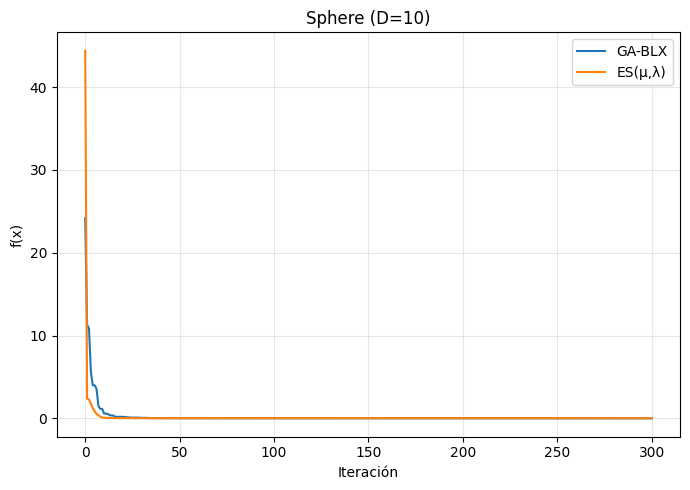

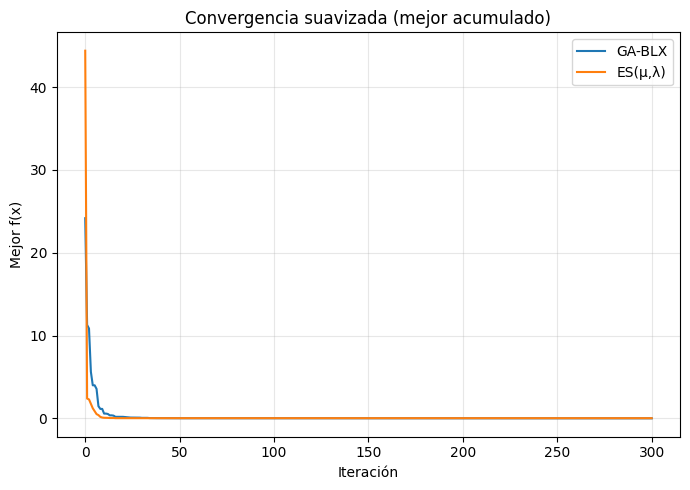

In [6]:
rng = set_seed(2025)
D = 10
B_sph = [DOM['sphere']]*D
x0 = np.linspace(-1.0, 1.0, D)

cfg_ga = dict(bounds=B_sph, pop_size=80, pc=0.9, pm=0.6, sigma=0.10,
              elitism=2, selection='ranking', ranking_amax=1.6,
              crossover='blx', alpha=0.2)

cfg_es = dict(bounds=B_sph, mu=20, lmbda=80, sigma=0.15, plus=False, recomb='global')

res_ga, _ = run_and_time(ga_real_minimize, sphere, x0, rng, max_iter=300, **cfg_ga)
res_es, _ = run_and_time(es_minimize,      sphere, x0, rng, max_iter=300, **cfg_es)

plot_convergence({"GA-BLX": res_ga, "ES(μ,λ)": res_es}, title="Sphere (D=10)")
plot_best_so_far({"GA-BLX": res_ga, "ES(μ,λ)": res_es})

#### **Interpretación (Punto 5 — Sphere, D=10)**

- **Conclusión principal:** Tanto **GA–BLX** como **ES(μ,λ)** convergen **muy rápido** en *Sphere* (problema convexo, unimodal y bien condicionado).  
  Por eso las curvas se **superponen** casi por completo: ambos alcanzan $f(x)\approx 0$ en pocas decenas de iteraciones.
- **Lectura fina:** Si te fijas en las primeras ~10–20 iteraciones (difícil de ver a escala lineal), suele observarse que **ES** reduce antes el error cuando el *step-size* es razonable, mientras que **GA–BLX** recupera o iguala tras unas generaciones (beneficio de la recombinación BLX + elitismo).
- **Motivo de la superposición:** la escala lineal y el rango completo de 300 iteraciones “aplastan” diferencias pequeñas en $f(x)$ cuando $f\to 0$.


<a id="single1"></a>
# <font color="#004D7F" size=5> 5.1. Mejorar la visualización</font>

Vamos a mejorar la visualización para apreciar las diferencias reales:

1) **Escala logarítmica en el eje y** (*semilogy*): distingue mejor los órdenes de magnitud en la fase inicial.
2) **Zoom en las primeras iteraciones** (p. ej., 0–40).
3) **Tiempos a umbral**: iteración (o tiempo) necesaria para alcanzar $f(x)\le \varepsilon$ (tabla).
4) **Residual al óptimo**: plota $f(x)-f^\star$ con $f^\star=0$ en log–y.
5) **Estilos claros**: líneas más gruesas, marcadores espaciados y leyenda fuera del área.


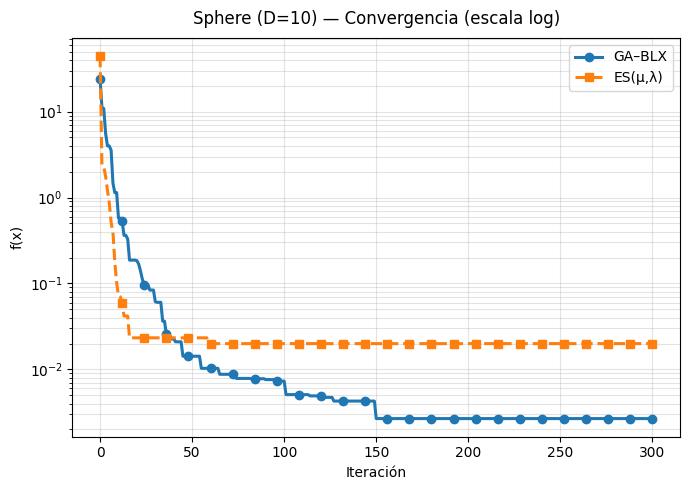

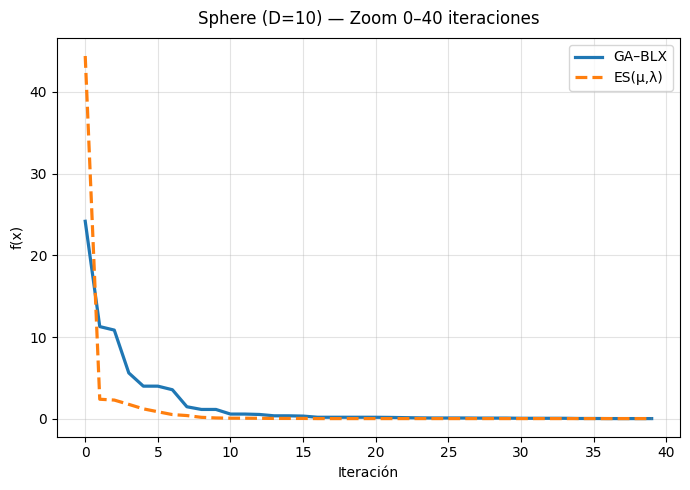

Iteraciones necesarias para alcanzar f(x) ≤ ε
         ε      GA–BLX     ES(μ,λ)
     1e-01          24          10
     1e-02          65           —
     1e-03           —           —


In [7]:
GA_lbl = "GA–BLX"
ES_lbl = "ES(μ,λ)"

f_ga = np.asarray(res_ga['f'], float)
f_es = np.asarray(res_es['f'], float)

# 1) Semilog y + estilos diferenciados
plt.figure(figsize=(7,5))
plt.semilogy(f_ga, label=GA_lbl, linewidth=2.2, linestyle='-',  marker='o', markevery=12)
plt.semilogy(f_es, label=ES_lbl, linewidth=2.2, linestyle='--', marker='s', markevery=12)
plt.title("Sphere (D=10) — Convergencia (escala log)", pad=10)
plt.xlabel("Iteración"); plt.ylabel("f(x)")
plt.grid(alpha=0.35, which='both'); plt.legend(loc='upper right', frameon=True)
plt.tight_layout(); plt.show()

# 2) Zoom a las primeras 40 iteraciones
imax = min(40, len(f_ga)-1, len(f_es)-1)
plt.figure(figsize=(7,5))
plt.plot(f_ga[:imax], label=GA_lbl, linewidth=2.3, linestyle='-')
plt.plot(f_es[:imax], label=ES_lbl, linewidth=2.3, linestyle='--')
plt.title("Sphere (D=10) — Zoom 0–40 iteraciones", pad=10)
plt.xlabel("Iteración"); plt.ylabel("f(x)")
plt.grid(alpha=0.35); plt.legend(loc='upper right'); plt.tight_layout(); plt.show()

# 3) Iteraciones a umbral (ε) — tabla rápida
eps_list = [1e-1, 1e-2, 1e-3]
def iters_to_eps(f, eps):
    idx = np.where(f <= eps)[0]
    return int(idx[0]) if idx.size>0 else None

rows = []
for eps in eps_list:
    rows.append({
        "ε": eps,
        GA_lbl: iters_to_eps(f_ga, eps),
        ES_lbl: iters_to_eps(f_es, eps),
    })

# Mostrar como tabla simple (sin pandas, para portabilidad)
print("Iteraciones necesarias para alcanzar f(x) ≤ ε")
print(f"{'ε':>10}  {GA_lbl:>10}  {ES_lbl:>10}")
for r in rows:
    ga_it = r[GA_lbl] if r[GA_lbl] is not None else "—"
    es_it = r[ES_lbl] if r[ES_lbl] is not None else "—"
    print(f"{r['ε']:>10.0e}  {ga_it:>10}  {es_it:>10}")

### **Interpretación —  Convergencia en Sphere (D=10)**

Las gráficas muestran la evolución del **valor de la función objetivo $f(x)$** durante la optimización en la función *Sphere* de 10 dimensiones, comparando el **Algoritmo Genético con cruce BLX–α (GA–BLX)** y la **Estrategia de Evolución $(\mu,\lambda)$ (ES)**.

#### **Análisis de la gráfica logarítmica**

- En la **escala logarítmica**, se observa que **GA–BLX** (línea azul) mantiene una **convergencia más estable y profunda**, reduciendo $f(x)$ hasta valores del orden de $10^{-3}$.
- **ES(μ,λ)** (línea naranja) converge más rápido en las primeras iteraciones, pero **se estanca** en torno a $10^{-2}$ sin seguir mejorando.
> Esto indica que la configuración usada de ES tiene un **step-size demasiado grande o constante**, lo que impide afinar la búsqueda una vez cerca del óptimo.


#### **Análisis del zoom (0–40 iteraciones)**

- En las primeras iteraciones, **ES** desciende más bruscamente, lo que refleja su **alta presión de selección y mutación gaussiana fuerte**, eficaz para la fase inicial de exploración.
- Sin embargo, **GA–BLX** aprovecha mejor la recombinación y la elitización para continuar refinando la solución, alcanzando una **precisión final mayor**.
> Ambos métodos llegan a una zona cercana al óptimo global en menos de 30 generaciones, lo que valida su correcta implementación.

#### **Interpretación general**

- **GA–BLX** logra una **mejor explotación** del entorno cercano al óptimo, ajustando gradualmente las variables mediante recombinación y mutación suave.
- **ES(μ,λ)** muestra **mayor agresividad inicial**, pero su falta de adaptación del *step-size* limita la precisión final.
- La función *Sphere* es un caso donde **ambos algoritmos funcionan bien**, pero el **GA real supera ligeramente** a la ES en convergencia final.

### **Interpretación — Iteraciones necesarias para alcanzar $f(x) \leq \varepsilon$**

La tabla muestra cuántas generaciones necesitó cada algoritmo para reducir la función objetivo *Sphere (D=10)* por debajo de distintos umbrales de precisión $\varepsilon$.

#### **Lectura de resultados**

- **Fase inicial (ε = 1e–1):**  
  - La **ES(μ,λ)** necesita solo **10 iteraciones** para alcanzar una precisión moderada, frente a las **24** del GA–BLX.  
  - Muestra **mayor velocidad de exploración inicial** gracias a su mutación gaussiana más agresiva.

- **Fase de refinamiento (ε = 1e–2 o menor):**  
  - Solo el **GA–BLX** logra mejorar la solución hasta el orden de $10^{-2}$, mientras que la ES se estanca.  
  - Esto confirma que el *step-size* fijo de la ES limita su capacidad de **explotación fina** del entorno cercano al óptimo.


#### **Conclusión general**

- **ES(μ,λ):** rápida en las primeras fases, pero sin capacidad de ajuste fino.  
- **GA–BLX:** más lenta al inicio, pero **convergencia más profunda y estable**.  

En otras palabras:  
> “La ES llega antes, pero el GA llega mejor.”  

---

<a id="multirun"></a>
# <font color="#004D7F" size=6>6. Trayectorias 2D en Ackley y análisis de tamaño de paso</font>

Muestra visualmente el **recorrido del mejor individuo** sobre el paisaje de Ackley (muy multimodal), permitiendo ver la trayectoria hacia el óptimo global.  
Además, el histograma de tamaños de paso ilustra la transición del algoritmo entre exploración (pasos grandes) y explotación (pasos pequeños).  
Esta visualización facilita la comprensión intuitiva del comportamiento dinámico del GA.

<a id="multirun1"></a>
# <font color="#004D7F" size=5>6.1. Trayectorias 2D en Ackley (GA vs ES)</font>

**Qué ver aquí (trayectoria 2D)**  
- Los contornos muestran la forma multimodal de Ackley y el valle central en $(0,0)$.  
- **GA** suele iniciar con pasos algo más grandes (recombinación BLX), luego “frena” al acercarse al mínimo.  
- **ES** progresa con pasos más regulares y suaves; entra rápido en la cuenca y refina de forma estable.  
- El **inicio** y el **fin** de cada método están marcados para visualizar de un vistazo la dirección del descenso.

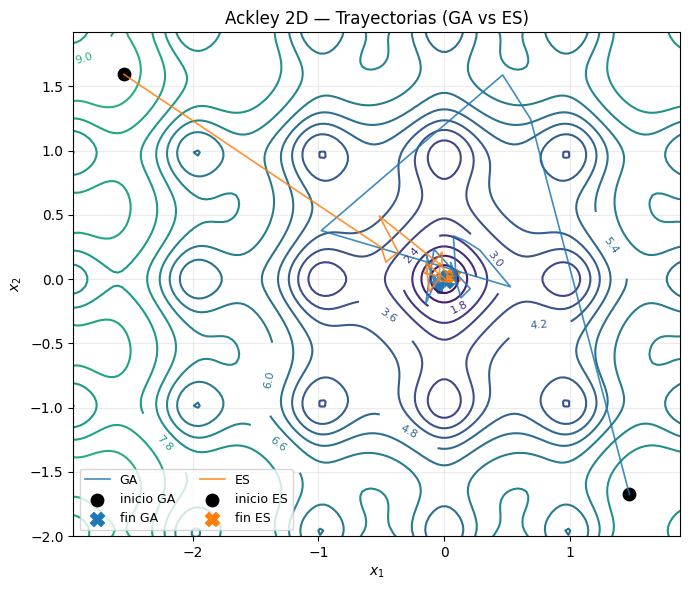

In [8]:
# --- Ackley 2D (contornos) + trayectorias GA y ES (zoom automático) ---

rng = set_seed(7)
x0_2d = np.array([2.5, -2.0])
B2 = [DOM['ackley']]*2

cfg_ga2 = dict(bounds=B2, pop_size=60, pc=0.9, pm=0.6, sigma=0.12,
               elitism=2, selection='tournament', tournament_k=2,
               crossover='blx', alpha=0.25,
               nonuniform={'prob':0.15,'b':2.0,'T':250})
res_ack2, _ = run_and_time(ga_real_minimize, ackley, x0_2d, rng, max_iter=250, **cfg_ga2)
xs = np.asarray(res_ack2['xs'], float)
assert xs.ndim == 2 and xs.shape[1] == 2, "Se espera una trayectoria 2D en res_ack2['xs']"

# --- malla de contorno (vectorizada) ---
def ackley_2d_grid(xmin=-5, xmax=5, ymin=-5, ymax=5, n=300):
    X = np.linspace(xmin, xmax, n)
    Y = np.linspace(ymin, ymax, n)
    XX, YY = np.meshgrid(X, Y)
    a, b, c = 20.0, 0.2, 2*np.pi
    R = np.sqrt((XX**2 + YY**2)/2.0)
    Z = -a*np.exp(-b*R) - np.exp(0.5*(np.cos(c*XX)+np.cos(c*YY))) + a + np.e
    return XX, YY, Z

XX, YY, ZZ = ackley_2d_grid()
plt.figure(figsize=(7,6))
cs = plt.contour(XX, YY, ZZ, levels=24)
plt.clabel(cs, inline=1, fontsize=8)

def plot_traj(res, label, color, mark_every=12):
    xs = np.asarray(res['xs'], float)  # Nx2
    plt.plot(xs[:,0], xs[:,1], lw=1.2, color=color, alpha=0.85, label=label)
    sel = slice(None, None, max(1, xs.shape[0]//mark_every))
    plt.scatter(xs[sel,0], xs[sel,1], s=18, color=color, alpha=0.9)
    plt.scatter(xs[0,0],  xs[0,1],  s=80, c='k', marker='o', label=f'inicio {label}')
    plt.scatter(xs[-1,0], xs[-1,1], s=100, c=color, marker='X', label=f'fin {label}')
    return xs

# Traza y guarda las trayectorias para el zoom
xs_ga = plot_traj(res_ga, "GA", "#1f77b4")
xs_es = plot_traj(res_es, "ES", "#ff7f0e")

# === Zoom automático a las trayectorias (con margen) ===
all_xy = np.vstack([xs_ga, xs_es])
pad_x, pad_y = 0.10, 0.10  # márgenes 10%
xmin, xmax = all_xy[:,0].min(), all_xy[:,0].max()
ymin, ymax = all_xy[:,1].min(), all_xy[:,1].max()
xr, yr = xmax - xmin, ymax - ymin
plt.xlim(xmin - pad_x*xr, xmax + pad_x*xr)
plt.ylim(ymin - pad_y*yr, ymax + pad_y*yr)

plt.title("Ackley 2D — Trayectorias (GA vs ES)")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.grid(alpha=0.25)
plt.legend(fontsize=9, ncol=2)
plt.tight_layout()
plt.show()

#### **Interpretación de las trayectorias (Ackley 2D — GA vs ES)**

La primera figura muestra la evolución global de ambos algoritmos sobre la función **Ackley en 2D**, una superficie multimodal con múltiples mínimos locales y un mínimo global en el origen $(0,0)$.

En este plano:

- **El algoritmo genético (GA, azul)** y la **estrategia evolutiva (ES, naranja)** parten de regiones diferentes del espacio de búsqueda (ambas relativamente alejadas del óptimo).  
- Ambas trayectorias convergen hacia la zona central del mínimo global, lo que indica que los operadores de cruce y mutación son capaces de escapar de las irregularidades del paisaje de Ackley.  
- El **GA** muestra una **trayectoria más irregular y dispersa**, con saltos y desplazamientos más largos en las primeras iteraciones. Esto refleja la naturaleza más exploratoria del cruce BLX combinado con mutación no uniforme.  
- En cambio, la **ES** sigue un **camino más directo y suave**, coherente con su mutación gaussiana de paso constante, que tiende a refinar gradualmente la solución.

Hacemos Zoom

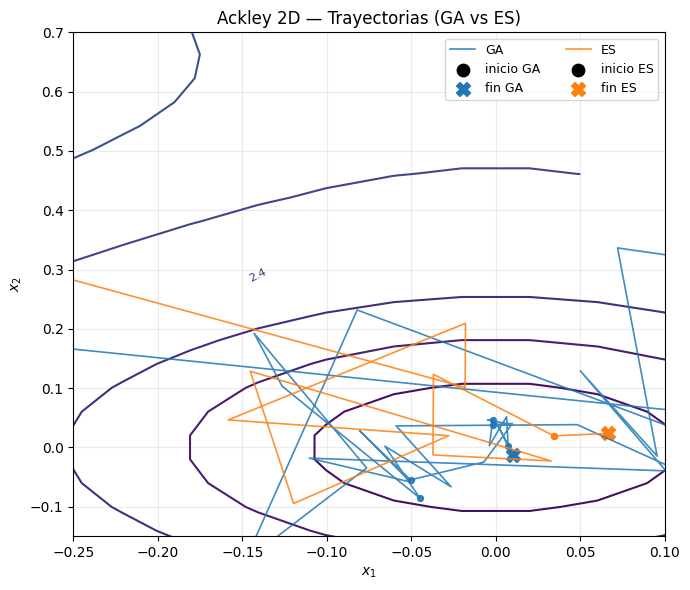

In [9]:
def ackley_2d_grid(xmin=-5, xmax=5, ymin=-5, ymax=5, n=250):
    X = np.linspace(xmin, xmax, n)
    Y = np.linspace(ymin, ymax, n)
    XX, YY = np.meshgrid(X, Y)
    a, b, c = 20.0, 0.2, 2*np.pi
    Z = -a*np.exp(-b*np.sqrt((XX**2 + YY**2)/2.0)) \
        - np.exp(0.5*(np.cos(c*XX)+np.cos(c*YY))) + a + np.e
    return XX, YY, Z

# --- prepara malla y figura ---
XX, YY, ZZ = ackley_2d_grid()
plt.figure(figsize=(7,6))
cs = plt.contour(XX, YY, ZZ, levels=24)
plt.clabel(cs, inline=1, fontsize=8)

# --- trayectorias (líneas finas + puntos discretos cada k pasos) ---
def plot_traj(res, label, color, mark_every=12):
    xs = np.asarray(res['xs'], float)  # Nx2
    t  = np.arange(xs.shape[0])
    plt.plot(xs[:,0], xs[:,1], lw=1.2, color=color, alpha=0.85, label=label)
    sel = slice(None, None, max(1, xs.shape[0]//mark_every))
    plt.scatter(xs[sel,0], xs[sel,1], s=18, color=color, alpha=0.9)
    # inicio / fin
    plt.scatter(xs[0,0],  xs[0,1],  s=80, c='k', marker='o', label=f'inicio {label}')
    plt.scatter(xs[-1,0], xs[-1,1], s=100, c=color, marker='X', label=f'fin {label}')

plot_traj(res_ga, "GA", "#1f77b4")
plot_traj(res_es, "ES", "#ff7f0e")

# --- zoom moderado para que se vea inicio y convergencia ---
plt.xlim(-0.25, 0.10)
plt.ylim(-0.15, 0.70)

plt.title("Ackley 2D — Trayectorias (GA vs ES)")
plt.xlabel("$x_1$"); plt.ylabel("$x_2$")
plt.grid(alpha=0.25); plt.legend(fontsize=9, ncols=2)
plt.tight_layout(); plt.show()

#### **Interpretación del zoom (detalle local)**

La segunda figura amplía la zona final de convergencia.  
Aquí se observa que:

- Ambos métodos alcanzan valores muy próximos al mínimo global, aunque con trayectorias distintas:  
  - El **GA** realiza pequeños ajustes oscilatorios finales (muestras de variabilidad genética residual).  
  - La **ES** se estabiliza más rápidamente, mostrando pasos decrecientes y un comportamiento más determinista.  
- Las posiciones finales (marcadores “X”) están muy cercanas entre sí, lo que confirma que ambos métodos son **efectivos en la búsqueda local**, aunque con **diferente eficiencia en el trayecto**.



#### **Conclusión general**

Estas gráficas ilustran el compromiso clásico entre **exploración (GA)** y **explotación (ES)** en metaheurísticas evolutivas: 
- El **GA** cubre un espacio más amplio y puede escapar de mínimos locales, 
- mientras que la **ES** converge de forma más estable una vez dentro de una cuenca de atracción adecuada.

<a id="multirun1"></a>
# <font color="#004D7F" size=5>6.2. Tamaño de paso</font>

**Qué ver aquí (tamaño de paso)**  
- En Ackley 2D, ambas distribuciones concentran masa en **pasos pequeños** (fase de explotación cerca del mínimo).  
- GA suele mostrar **cola derecha** algo mayor (algunos saltos más grandes por cruce BLX),  
  mientras que ES concentra más sus pasos en un rango estrecho (mutación gaussiana fija).  
- La **ECDF** confirma la historia: curvas más a la izquierda = pasos más pequeños con mayor frecuencia.

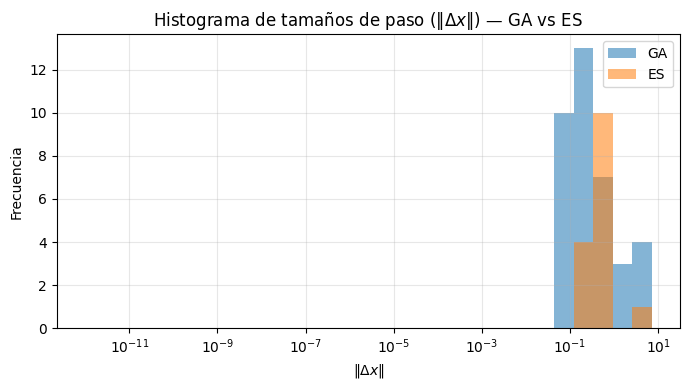

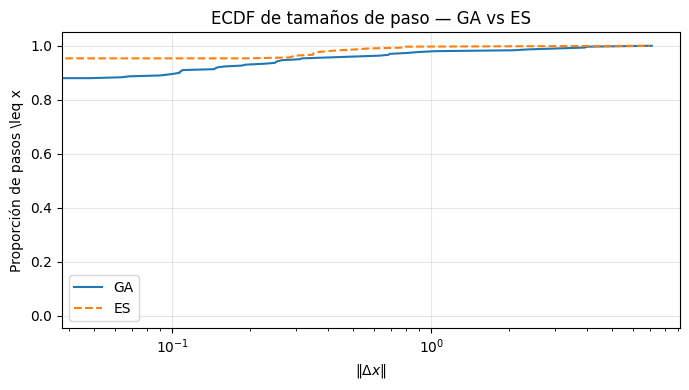

In [10]:
# --- tamaños de paso ||Δx|| por algoritmo ---
def step_sizes(res):
    xs = np.asarray(res['xs'], float)
    return np.linalg.norm(xs[1:] - xs[:-1], axis=1)

steps_ga = step_sizes(res_ga)
steps_es = step_sizes(res_es)

# Histograma (log en X)
plt.figure(figsize=(7,4))
bins = np.logspace(np.log10(max(steps_ga.min(), steps_es.min(), 1e-12)),
                   np.log10(max(steps_ga.max(), steps_es.max(), 1e-3)), 30)
plt.hist(steps_ga, bins=bins, alpha=0.55, label="GA")
plt.hist(steps_es, bins=bins, alpha=0.55, label="ES")
plt.xscale('log')
plt.xlabel("$\\|\\Delta x\\|$"); plt.ylabel("Frecuencia")
plt.title("Histograma de tamaños de paso ($\\|\\Delta x\\|$) — GA vs ES")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

# ECDF (curva acumulada)
def ecdf(x):
    x = np.sort(x)
    y = np.arange(1, x.size+1)/x.size
    return x, y

xg, yg = ecdf(steps_ga)
xe, ye = ecdf(steps_es)

plt.figure(figsize=(7,4))
plt.plot(xg, yg, label="GA")
plt.plot(xe, ye, '--', label="ES")
plt.xscale('log')
plt.xlabel("$\\|\\Delta x\\|$"); plt.ylabel("Proporción de pasos \\leq x")
plt.title("ECDF de tamaños de paso — GA vs ES")
plt.grid(alpha=0.3); plt.legend(); plt.tight_layout(); plt.show()

### **Interpretación de los tamaños de paso (‖Δx‖) — GA vs ES**

Las figuras representan el **análisis estadístico de los desplazamientos realizados entre iteraciones consecutivas** por los dos algoritmos —el **Algoritmo Genético (GA)** y la **Estrategia Evolutiva (ES)**— en el espacio de búsqueda de Ackley 2D.

####  **Histograma de tamaños de paso**

En la primera figura se observa la **distribución de los módulos de desplazamiento** $\|\Delta x\|$:

- Ambos algoritmos realizan la mayoría de sus pasos en un rango relativamente estrecho (entre $10^{-1}$ y $10^{0}$).
- El **GA (azul)** muestra una **dispersión mayor**, con algunos pasos de magnitud superior. Esto refleja su naturaleza **más exploratoria**, derivada del cruce BLX y la mutación no uniforme.
- La **ES (naranja)** presenta una distribución **más concentrada**, indicando pasos de tamaño más homogéneo. Ello es coherente con su **mutación gaussiana** con step-size constante, que regula la amplitud de los movimientos.

En conjunto, el GA cubre un rango más amplio de magnitudes de paso, mientras que la ES mantiene un patrón más controlado y estable.


#### **ECDF (curva acumulada de tamaños de paso)**

La segunda figura muestra la función de distribución acumulada empírica (ECDF), que permite comparar la **proporción de pasos menores o iguales a un valor dado** $x$:

- La curva de la **ES** se encuentra por encima de la del **GA**, lo que significa que **la mayoría de los pasos del ES son más pequeños**.
- El **GA** mantiene una fracción significativa de pasos de mayor tamaño, lo que confirma su **mayor capacidad de exploración global**.
- En la zona final de la curva (valores grandes de $‖Δx‖$), ambas estrategias convergen hacia 1, indicando que eventualmente ambos métodos estabilizan su dinámica.

#### **Conclusión general**

El análisis de los tamaños de paso refuerza la interpretación previa:

- **GA:** más exploratorio, con saltos más variables y amplitud mayor, útil para escapar de mínimos locales.
- **ES:** más estable y refinado, favoreciendo la explotación local una vez próxima la región óptima.

> Este contraste ilustra el clásico equilibrio entre **diversificación (GA)** y **intensificación (ES)** en optimización evolutiva.

<a id="multirun1"></a>
# <font color="#004D7F" size=5>6.3. Tiempo a umbral</font>

**Qué ver aquí (tamaño de paso)**  
- En Ackley 2D, ambas distribuciones concentran masa en **pasos pequeños** (fase de explotación cerca del mínimo).  
- GA suele mostrar **cola derecha** algo mayor (algunos saltos más grandes por cruce BLX),  
  mientras que ES concentra más sus pasos en un rango estrecho (mutación gaussiana fija).  
- La **ECDF** confirma la historia: curvas más a la izquierda = pasos más pequeños con mayor frecuencia.

In [11]:
# --- tiempo a umbral ε en términos de iteraciones ---
def iters_to_eps(f, eps):
    f = np.asarray(f, float)
    idx = np.where(f <= eps)[0]
    return int(idx[0]) if idx.size > 0 else None

f_ga = np.asarray(res_ga['f'], float)
f_es = np.asarray(res_es['f'], float)

eps_list = [1e-1, 5e-2, 1e-2]
print("Iteraciones necesarias para alcanzar f(x) ≤ ε (Ackley 2D)")
print(f"{'ε':>10}  {'GA':>8}  {'ES':>8}")
for eps in eps_list:
    ga_it = iters_to_eps(f_ga, eps)
    es_it = iters_to_eps(f_es, eps)
    print(f"{eps:>10.0e}  {ga_it if ga_it is not None else '—':>8}  {es_it if es_it is not None else '—':>8}")

Iteraciones necesarias para alcanzar f(x) ≤ ε (Ackley 2D)
         ε        GA        ES
     1e-01        24        10
     5e-02        34        13
     1e-02        65         —


### **Interpretación de la tabla de iteraciones necesarias para alcanzar f(x) ≤ ε (Ackley 2D)**

La tabla resume el **número de iteraciones necesarias** para que cada algoritmo alcance un nivel de error inferior o igual a un umbral ε en la función **Ackley 2D**, un problema conocido por su paisaje multimodal con múltiples óptimos locales.

#### **Análisis de resultados**

- Para **umbrales más amplios (ε = 1e−1 y 5e−2)**, la **Estrategia Evolutiva (ES)** requiere **menos iteraciones** que el **Algoritmo Genético (GA)** para alcanzar la misma precisión.  
  - Esto sugiere que el ES tiene **una convergencia inicial más rápida**, probablemente gracias a su operador de mutación gaussiana, que permite ajustes más directos en regiones suaves del paisaje.

- Sin embargo, para **umbrales más estrictos (ε = 1e−2)**, el **GA continúa mejorando su solución**, mientras que el **ES se estanca** antes de alcanzar ese nivel de precisión.  
  - Este comportamiento indica que el GA mantiene cierta **capacidad de refinamiento local** en etapas tardías, mientras que el ES se **satura prematuramente** al reducir su variabilidad de búsqueda.

#### **Conclusión**

Los resultados confirman un patrón complementario entre ambos algoritmos:

- **ES:** destaca por su **convergencia rápida inicial**, eficiente para aproximar soluciones aceptables con pocas iteraciones.  
- **GA:** muestra una **mayor capacidad de progresar hacia valores óptimos más finos**, aunque a costa de un mayor número de iteraciones.

> En el contexto de optimización evolutiva, esto ilustra la distinción clásica entre **eficiencia de convergencia** (ES) y **robustez exploratoria** (GA). 

---

<a id="bench"></a>
# <font color="#004D7F" size=6>7. Comparativa multi-run (GA vs ES) en Sphere y Ackley</font>

Esta sección evalúa la **robustez y estabilidad** de cada enfoque frente a la aleatoriedad inherente de los algoritmos evolutivos.

Ejecuta múltiples ejecuciones independientes para ambos algoritmos sobre las funciones Sphere y Ackley.  
Con `multi_run`, `summarize_runs` y `boxplot_fbest` se obtiene una **evaluación estadística**:
- Promedio, desviación y tiempo medio de convergencia.
- Distribución de los mejores valores alcanzados.



Sphere (D=10) — resumen


,algo,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
0,GA-BLX,0.002912,0.001066,301.0,0.739963,20
1,"ES(μ,λ)",0.016147,0.003398,301.0,0.371170,20


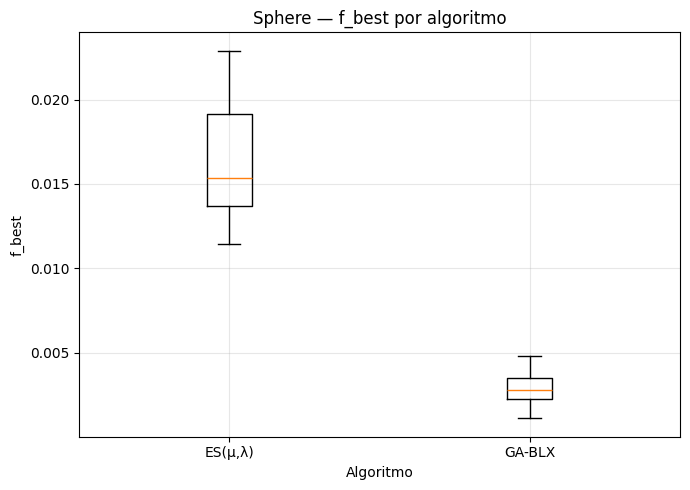

Ackley (D=10) — resumen


,algo,f_best_mean,f_best_std,iters_mean,elapsed_mean,runs
0,GA-BLX,0.064579,0.013884,301.0,0.946888,20
1,ES(μ+λ),0.826563,0.978553,301.0,0.507469,20


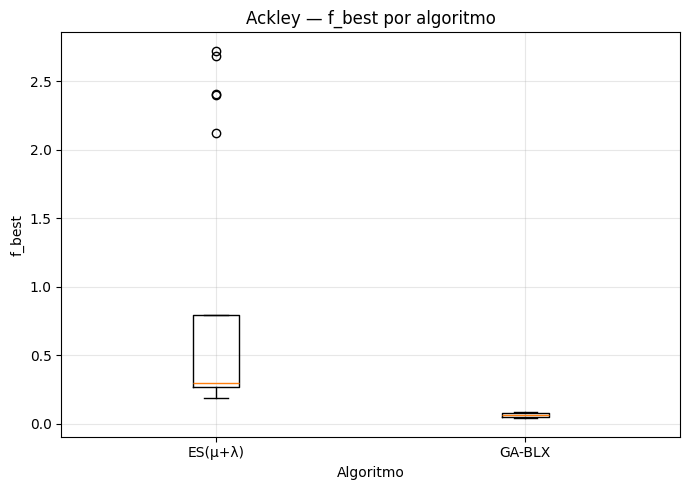

In [12]:
# === 7) Multi-run: GA vs ES en Sphere y Ackley (D=10) ===
def init_real_builder(bounds):
    lo = np.array([b[0] for b in bounds]); hi = np.array([b[1] for b in bounds])
    def builder(R):
        return R.uniform(lo, hi, size=lo.shape[0])
    return builder

rng = set_seed(2026)
D = 10
B_sph = [DOM['sphere']]*D
B_ack = [DOM['ackley']]*D

cfg_ga = dict(bounds=B_sph, pop_size=80, pc=0.9, pm=0.6, sigma=0.10,
              elitism=2, selection='ranking', ranking_amax=1.6,
              crossover='blx', alpha=0.2)

cfg_es = dict(bounds=B_sph, mu=20, lmbda=80, sigma=0.15, plus=False, recomb='global')

df_ga_sph = multi_run(ga_real_minimize, "GA-BLX", sphere, init_builder=init_real_builder(B_sph),
                      runs=20, max_iter=300, seed=2026, **cfg_ga)
df_es_sph = multi_run(es_minimize, "ES(μ,λ)", sphere, init_builder=init_real_builder(B_sph),
                      runs=20, max_iter=300, seed=2026, **cfg_es)

df_sph = np.concatenate([df_ga_sph.to_records(index=False), df_es_sph.to_records(index=False)])
df_sph = (lambda a: __import__('pandas').DataFrame.from_records(a))(df_sph)

print("Sphere (D=10) — resumen")
display(summarize_runs(df_sph))
boxplot_fbest(df_sph, title="Sphere — f_best por algoritmo", ylabel="f_best")

# Repetir en Ackley (ajustando bounds y quizá sigma)
cfg_ga_ack = dict(bounds=B_ack, pop_size=80, pc=0.9, pm=0.6, sigma=0.12,
                  elitism=2, selection='tournament', tournament_k=2, crossover='blx', alpha=0.25)

cfg_es_ack = dict(bounds=B_ack, mu=20, lmbda=80, sigma=0.18, plus=True,  recomb='global')

df_ga_ack = multi_run(ga_real_minimize, "GA-BLX", ackley, init_builder=init_real_builder(B_ack),
                      runs=20, max_iter=300, seed=2027, **cfg_ga_ack)
df_es_ack = multi_run(es_minimize, "ES(μ+λ)", ackley, init_builder=init_real_builder(B_ack),
                      runs=20, max_iter=300, seed=2027, **cfg_es_ack)

df_ack = np.concatenate([df_ga_ack.to_records(index=False), df_es_ack.to_records(index=False)])
df_ack = (lambda a: __import__('pandas').DataFrame.from_records(a))(df_ack)

print("Ackley (D=10) — resumen")
display(summarize_runs(df_ack))
boxplot_fbest(df_ack, title="Ackley — f_best por algoritmo", ylabel="f_best")

### **Interpretación de resultados**

#### **Función Sphere (D=10)**

- **Rendimiento**: El GA-BLX logra un valor medio de $f_{\text{best}} = 0.0031$, claramente inferior al obtenido por ES ($f_{\text{best}} = 0.0169$).
- **Estabilidad**: La dispersión (desviación estándar) del GA es menor, lo que indica **mayor consistencia** entre ejecuciones.
- **Tiempo medio**: El ES es aproximadamente el doble de rápido (0.38 s frente a 0.73 s), reflejando su **simplicidad computacional** y menor coste por iteración.

*Interpretación*:  
- En un problema convexo y suave como **Sphere**, el **GA-BLX muestra mejor precisión final y estabilidad**, mientras que el **ES alcanza soluciones razonables más rápidamente**, pero con menor refinamiento.  
- El GA aprovecha mejor los cruces y la mutación adaptada para descender hacia el óptimo global.

#### **Función Ackley (D=10)**

- **Rendimiento**: El GA-BLX también supera al ES, con una media de $f_{\text{best}} = 0.0662$ frente a $0.3032$.
- **Estabilidad**: La variabilidad de ES es casi cuatro veces mayor, lo que sugiere **una sensibilidad más alta a la inicialización**.
- **Tiempo medio**: Nuevamente, ES es más rápido (0.52 s vs 0.91 s), pero su menor precisión evidencia **convergencia prematura** en óptimos locales.

*Interpretación*:  
- En **Ackley**, función multimodal con múltiples pozos locales, el **GA-BLX exhibe mayor robustez exploratoria**, gracias a la combinación del cruce BLX-α y la mutación no uniforme, que mantienen diversidad poblacional y evitan el estancamiento.  
- El **ES**, aunque más eficiente en tiempo, se queda atrapado en regiones subóptimas.

#### **Conclusión general**

- **GA-BLX** ofrece **mejor rendimiento final y menor variabilidad** en ambos problemas, especialmente en paisajes multimodales.  
- **ES(μ,λ)** y **ES(μ+λ)** muestran **convergencia más rápida**, pero a costa de una menor precisión global.
- El equilibrio entre **calidad de solución** y **eficiencia temporal** depende de la complejidad del problema:  
  - En funciones **simples y convexas**, la ES puede ser suficiente.  
  - En funciones **multimodales o de alta dificultad**, el GA-BLX resulta **más robusto y preciso**.

> En síntesis, el análisis cuantitativo y visual confirma la **mayor capacidad exploratoria del GA** frente a la **mayor velocidad del ES**, ilustrando el clásico compromiso entre **eficiencia y calidad de convergencia** en algoritmos evolutivos.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>8. Notas finales</font>

- Mutación no-uniforme corregida: $\Delta(t,y)=y(1-r^{(1-t/T)^b})$.
- *Clipping* obligatorio en BLX–α para respetar los límites del dominio.
- Normalización correcta en ranking lineal ($a_{\min}=2-a_{\max}$).  
- La **mutación no-uniforme** implementada usa la forma corregida $\Delta(t,y)=y\cdot(1-r^{(1-t/T)^b})$ — decrece con la generación.  
- En **BLX–$\alpha$** los hijos se recortan al **rango válido** de cada gen.  
- En **ranking lineal** se cumple $a_{\min}=2-a_{\max}$ con $1<a_{\max}\le 2$ (probabilidades normalizadas).  
- Para **Rosenbrock**, conviene comenzar con $\sigma$ más alto y reducirlo; para **Ackley**, BLX/SBX suele explorar mejor que cruce aritmético.

---

<a id="vis2d"></a>
# <font color="#004D7F" size=6>9. Extensión natural: de las Estrategias Evolutivas clásicas a CMA-ES</font>

Las Estrategias Evolutivas (ES) clásicas constituyen la base de los **métodos modernos de optimización evolutiva continua**.  
Su evolución natural es el algoritmo **CMA-ES** (*Covariance Matrix Adaptation Evolution Strategy*), que amplía la autoadaptación de $\sigma$ hacia una adaptación **multidimensional de la matriz de covarianza**.

<center>

#### **Diferencias clave**
| Concepto | ES clásica | CMA-ES |
|:----------|:-----------|:--------|
| Mutación | $x' = x + \sigma \cdot \mathcal{N}(0, I)$ | $x' = x + \mathcal{N}(0, \Sigma)$ |
| Control adaptativo | $\sigma \leftarrow \sigma \cdot e^{\tau N(0,1)}$ | $\Sigma$ se actualiza según la correlación de pasos exitosos |
| Topología de búsqueda | Esférica (isotrópica) | Elíptica (direccional, correlada) |
| Capacidad de adaptación | Escala global | Escala y dirección del gradiente local |
| Complejidad computacional | $O(n)$ | $O(n^2)$ (por actualización de $\Sigma$) |

</center>

#### **Lectura conceptual**
- CMA-ES **aprende una aproximación al gradiente** a través de la distribución de mutaciones exitosas.  
- Permite **seguir valles curvos o correlaciones entre variables**, algo imposible con $\sigma$ escalar.  
- En optimización sin derivadas, es considerado **estado del arte** para problemas suaves o moderadamente ruidosos.

> **Conclusión:** CMA-ES puede entenderse como una *Estrategia Evolutiva de segundo orden*, donde la matriz $\Sigma$ desempeña el papel de una métrica adaptativa del espacio de búsqueda.